# Segmentación semántica


La segmentación semántica es una técnica que consiste en clasificar cada pixel de una imágen en una categoría o clase predefinida. Por ejemplo, en una imágen con personas y autos, la segmentación semántica etiquetará los pixeles que pertenecen unicamente a personas, y usará otra etiqueta para los pixeles que pertenecen a la clase carros.

La segmentación semántica es útil para diferenciar distintas clases de objetos pero no separa las instancias. Siguiendo el ejemplo anterior, se pueden distinguir las personas pero no se hace la separación de cada persona. El proceso de segmentación semántica se logra generalmente con `modelos de aprendizaje profundo`, especialmente con redes neurales convolucionales `CNNs`.

El modelo utiliza la `convolución atrous`. Este tipo de convolución agrega el parámetro `dilatation rate (r)`, que introduce espacios entre los puntos del kernel. El objetivo es obtener un mejor contexto de la imágen en cada evaluación de los pixeles del kernel sin sacrificar procesamiento. Un kernel en la convolución atrous con `rate=1` de `3x3` es igual a un kernel convencional `3x3`. La siguiente imágen muestra como se vería el kernel con `rate=2` y `rate=3`, en ella se pueden apreciar los espacios que se agregan.

<img style="width: 50%; display: block; margin: auto;" src="./resources/atrous-deeplab.png"/>

El resultado de la segmentación semántica es una máscara de segmentación donde cada clase de objeto tiene un color asociado.

## Segmentación semántica de autos con DeepLabv3 Resnet101

`deeplabv3_resnet101` es un modelo pre-entrenado de PyTorch. El modelo esta entrenado con un subconjunto del dataset `COCO` y hace uso de 20 de las categorías que se encuentran presente en el dataset de `Pascal VOC`. Para este ejercicio se utilizará la `categoría 7` que representa los automóviles, de esta forma probaremos el modelo con distintas imágenes de autos vistos desde arriba.

Cabe mencionar que los automóviles que se usaron en el entrenamiento del dataset `COCO` son mayormente de autos vistos de manera ya sea frontal, lado o posterior. Esto se puede comprobar en la página de exploración del dataset <a href='https://cocodataset.org/#explore' target='_blank'>https://cocodataset.org/#explore</a>. Aún asi se probará el modelo usando las imagenes de autos vistos de arriba de distintas maneras para verificar los resultados.

<img style="width: 50%; display: block; margin: auto;" src="./resources/atrous-deeplab.png"/>

### Código

- get_img_with_arr
  - Carga la imágen especificada y su array
- load_model
  - Carga el modelo de DeepLabV3 resnet101
- semantic_segmentation
  - Genera la máscara de la segmentación semántica sobre la imágen que se pasa como parámetro
- show_images
  - Muestra la imágen original, imágen de ground truth e imágen de la máscara de segmentación semántica
- calculate_iou
  - Cálculo `Intersection Over Union` para evaluar la máscara generada en la segmentación

El código de las funciones `load_model` y `semantic_segmentation` fue tomado en su mayoria de la página oficial de PyTorch: <a href='https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/' target='_blank'>https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/</a>

Se hicieron unas modificaciones especialmente en la parte en como el modelo selecciona las probabilidades de los pixeles para cada categoría. El ejemplo en PyTorch utiliza `argmax`, para obtener la predicción máxima de cada clase. El resultado fue una mala predicción para los automóviles y objetos en general, esto se puede apreciar en la siguiente imágen.

<img style="width: 30%; display: block; margin: auto;" src="./resources/armax_car.png"/>

Para corregir el problema de `argmax`, se aplicó `sigmoid` para convertir la predicción a probabilidades (valores de 0 a 1) y se añadió un parámetro de `probabilidad mínima`. Esto permite seleccionar la clase de un pixel siempre que la probabilidad sea como mínimo el valor que se asigne a `min_prob`. Adicionalmente se agregó al código el cálculo de la probabilidad unicamente para automóviles (`car_index = 7`).

In [ ]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

def get_img_with_arr(img_path):
    img_original = Image.open(img_path).convert('RGB')# Convert to RGB to avoid 4 channel problems
    img_original_arr = np.array(img_original)
    return (img_original, img_original_arr)

def load_model():
    model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
    model.eval()
    return model

def semantic_segmentation(model, img_path, min_prob = 0.90):
    # Load image
    img_original, _ = get_img_with_arr(img_path)

    # Configure the model
    preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    input_batch = preprocess(img_original).unsqueeze(0)

    # Use cuda if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out']

    # Convert to probabilities (value between 0 and 1), cars only
    car_index = 7
    car_prob = output[0][car_index].sigmoid()

    # Select pixels where probability of being a car is > min_prob
    mask_1d = (car_prob > min_prob).cpu().numpy().astype(np.uint8)

    # Turn 1d array into a 3d array
    mask_2d = mask_1d.reshape(mask_1d.shape)
    mask_3d = np.zeros((mask_1d.shape[0],mask_1d.shape[1], 3), dtype=np.uint8)
    mask_3d[mask_2d == 1, 0] = 255
    mask_3d[mask_2d == 1, 1] = 255
    mask_3d[mask_2d == 1, 2] = 255

    return (img_original, mask_3d)

def show_images(img_original, img_gt, img_pred):
    # Display images side by side
    plt.figure(figsize=(20, 5), num='Semantic Segmentation')

    for index, img in enumerate([img_original, img_gt, img_pred]):
        plt.subplot(1, 3, index+1)
        plt.title(img['title'])
        plt.imshow(img['img_data'])
        plt.axis('off')

    plt.show()

def calculate_iou(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / union    

model = load_model()


Intersection over Union -> car1: 0.4116702869769589
Intersection over Union -> car2: 0.8840349047801986
Intersection over Union -> car3: 0.289845057103368


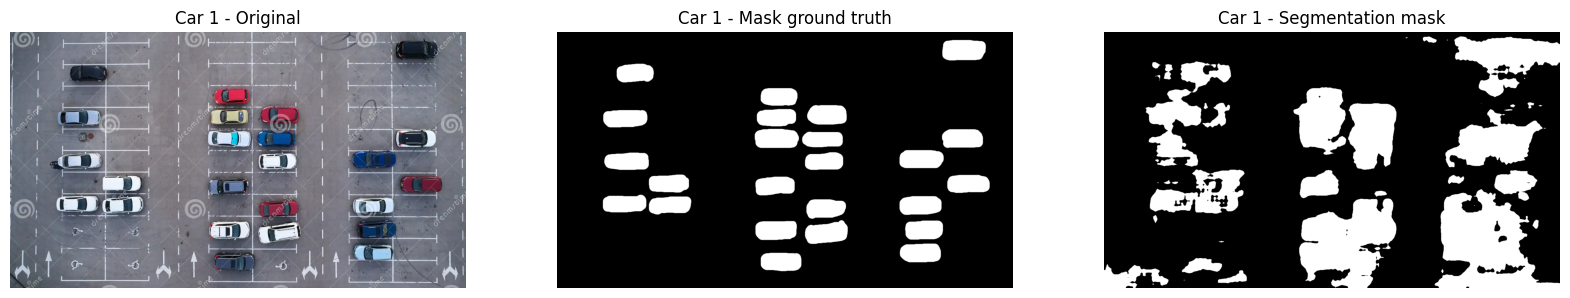

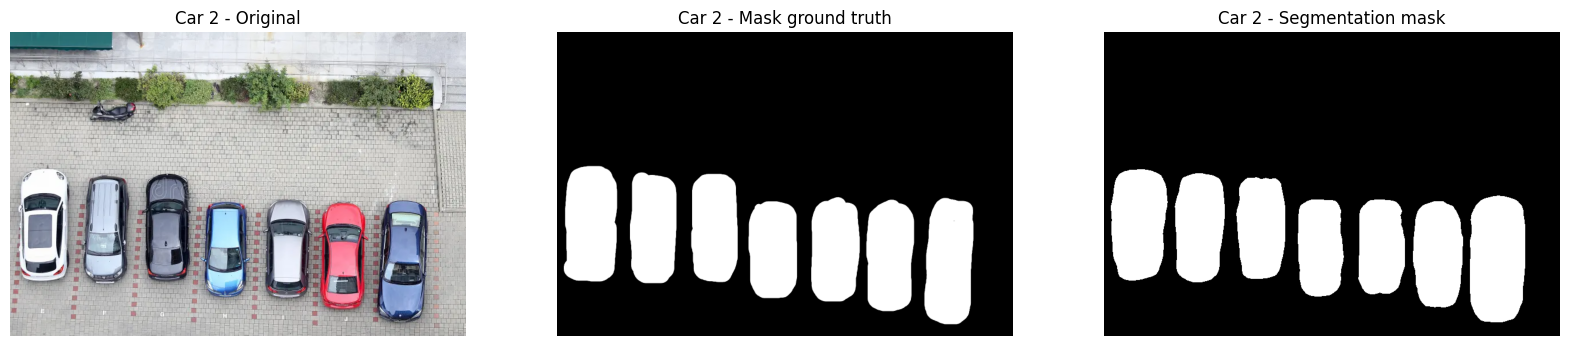

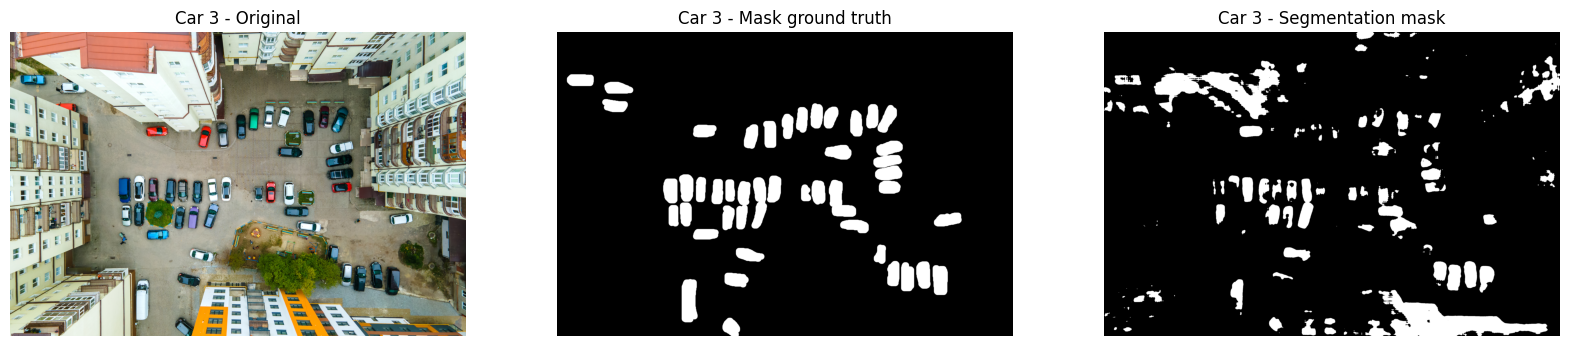

In [15]:
# Get segmentation mask images
car1, pred_mask_car_arr1 = semantic_segmentation(model, './cars_startup/car1.png')
car2, pred_mask_car_arr2 = semantic_segmentation(model, './cars_startup/car2.png')
car3, pred_mask_car_arr3 = semantic_segmentation(model, './cars_startup/car3.png')

# Load ground truth images
_, gt_mask_car_arr1 = get_img_with_arr('./cars_ground_truth/car1_ground_truth.png')
_, gt_mask_car_arr2 = get_img_with_arr('./cars_ground_truth/car2_ground_truth.png')
_, gt_mask_car_arr3 = get_img_with_arr('./cars_ground_truth/car3_ground_truth.png')

# Ground Truth - Calculate Intersection over Union
print('Intersection over Union -> car1: ' + str(calculate_iou(pred_mask_car_arr1, gt_mask_car_arr1)))
print('Intersection over Union -> car2: ' + str(calculate_iou(pred_mask_car_arr2, gt_mask_car_arr2)))
print('Intersection over Union -> car3: ' + str(calculate_iou(pred_mask_car_arr3, gt_mask_car_arr3)))

# Display original images and masks
show_images({ 'title': 'Car 1 - Original', 'img_data': car1 }, { 'title': 'Car 1 - Mask ground truth', 'img_data': gt_mask_car_arr1 }, { 'title': 'Car 1 - Segmentation mask', 'img_data': pred_mask_car_arr1})
show_images({ 'title': 'Car 2 - Original', 'img_data': car2 }, { 'title': 'Car 2 - Mask ground truth', 'img_data': gt_mask_car_arr2 }, { 'title': 'Car 2 - Segmentation mask', 'img_data': pred_mask_car_arr2})
show_images({ 'title': 'Car 3 - Original', 'img_data': car3 }, { 'title': 'Car 3 - Mask ground truth', 'img_data': gt_mask_car_arr3 }, { 'title': 'Car 3 - Segmentation mask', 'img_data': pred_mask_car_arr3})

Intersection over Union -> car1         : 0.42853157110174017
Intersection over Union -> car1 vertical: 0.6229165665090031


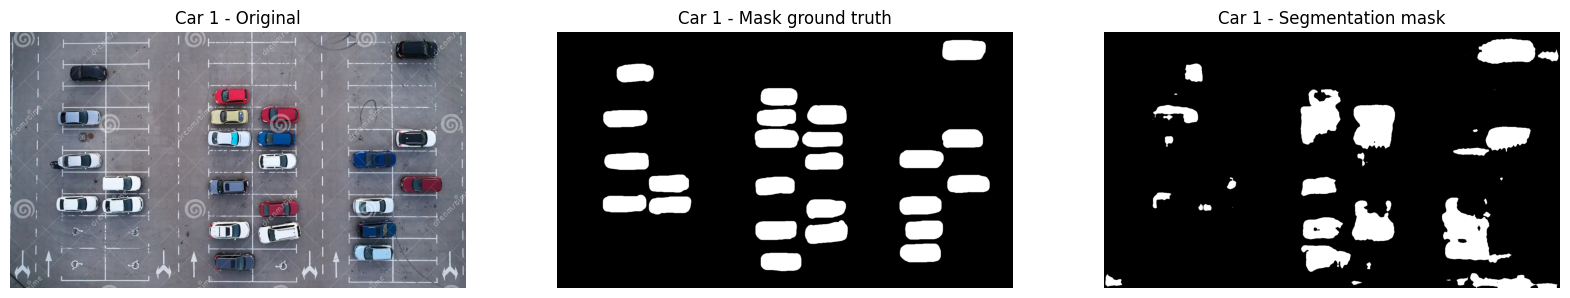

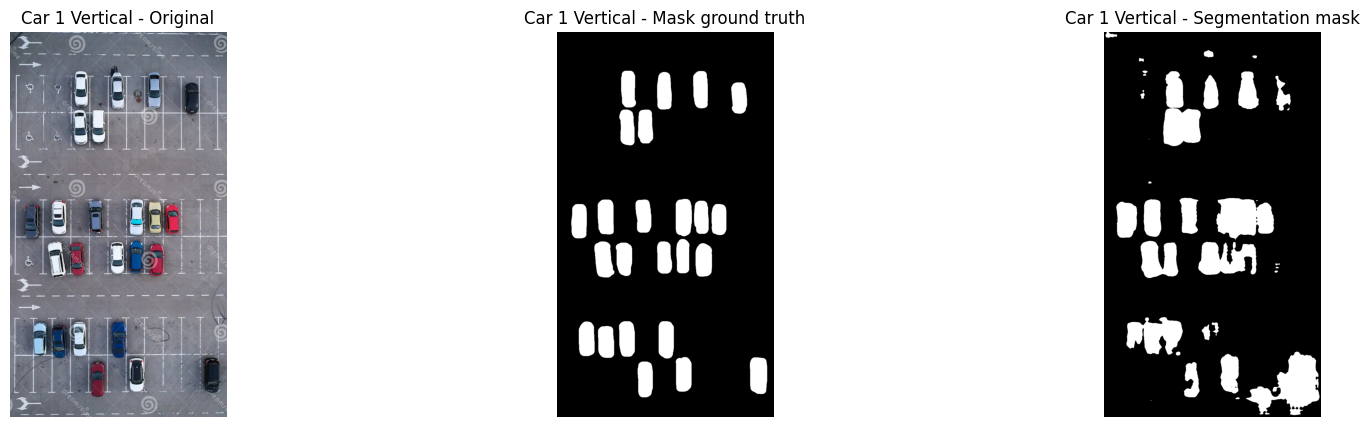

In [16]:
# Get segmentation mask image
car1, pred_mask_car_arr1 = semantic_segmentation(model, './cars_startup/car1.png', min_prob=0.95)
car1_vertical, pred_mask_car_vertical_arr1 = semantic_segmentation(model, './cars_startup/car1_vertical.png', min_prob=0.95)

# Load ground truth image
_, gt_mask_car_vertical_arr1 = get_img_with_arr('./cars_ground_truth/car1_vertical_ground_truth.png')

# Ground Truth - Calculate Intersection over Union
print('Intersection over Union -> car1         : ' + str(calculate_iou(pred_mask_car_arr1, gt_mask_car_arr1)))
print('Intersection over Union -> car1 vertical: ' + str(calculate_iou(pred_mask_car_vertical_arr1, gt_mask_car_vertical_arr1)))

# Display original image and masks
show_images({ 'title': 'Car 1 - Original', 'img_data': car1 }, { 'title': 'Car 1 - Mask ground truth', 'img_data': gt_mask_car_arr1 }, { 'title': 'Car 1 - Segmentation mask', 'img_data': pred_mask_car_arr1})
show_images({ 'title': 'Car 1 Vertical - Original', 'img_data': car1_vertical }, { 'title': 'Car 1 Vertical - Mask ground truth', 'img_data': gt_mask_car_vertical_arr1 }, { 'title': 'Car 1 Vertical - Segmentation mask', 'img_data': pred_mask_car_vertical_arr1})

Intersection over Union -> car3             : 0.289845057103368
Intersection over Union -> car3 vertical    : 0.34255260810562227
Intersection over Union -> car3 cut         : 0.26564403954784177
Intersection over Union -> car3 cut vertical: 0.6922406719255519


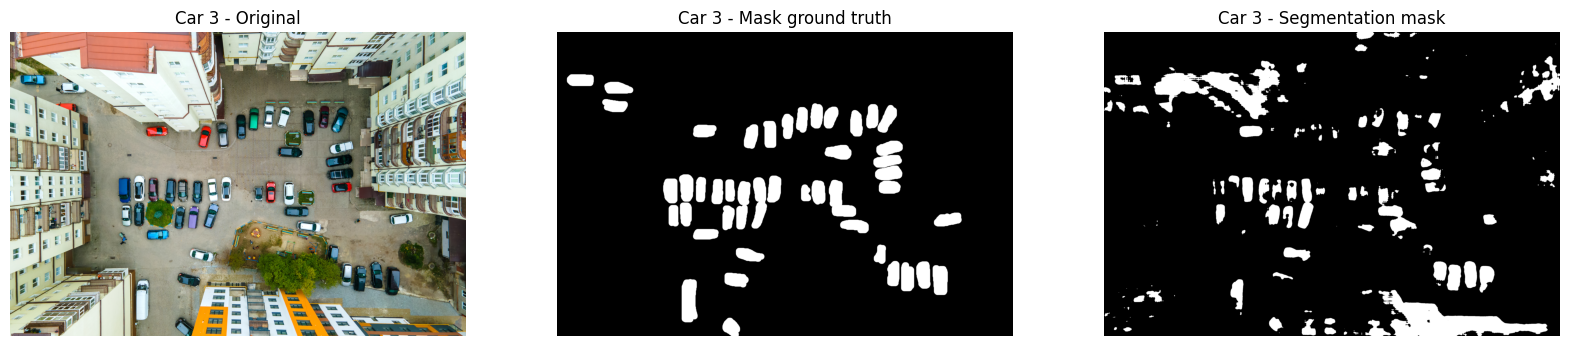

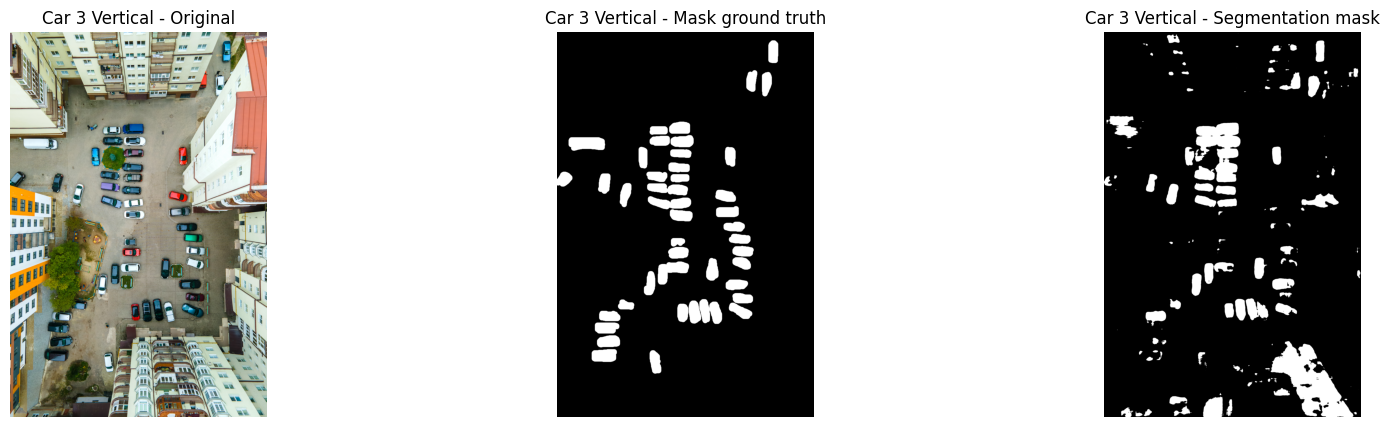

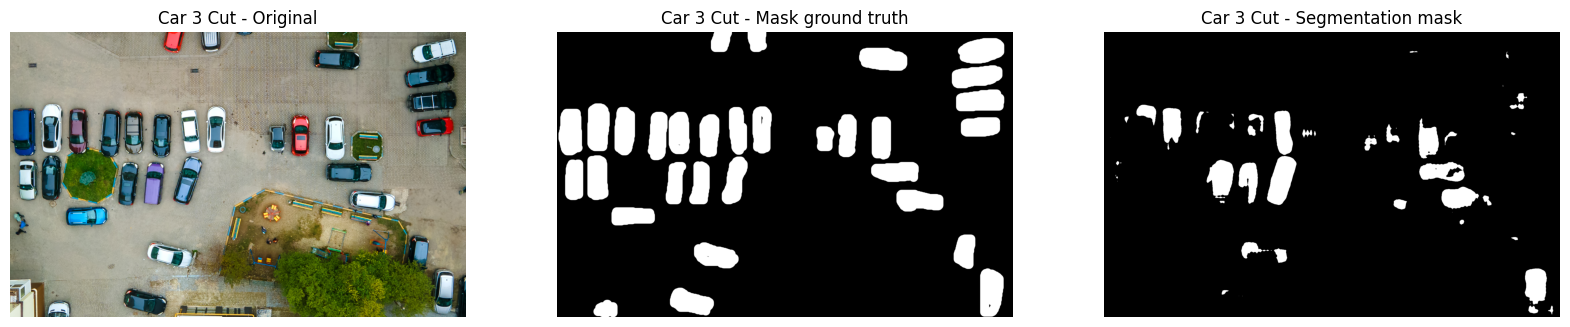

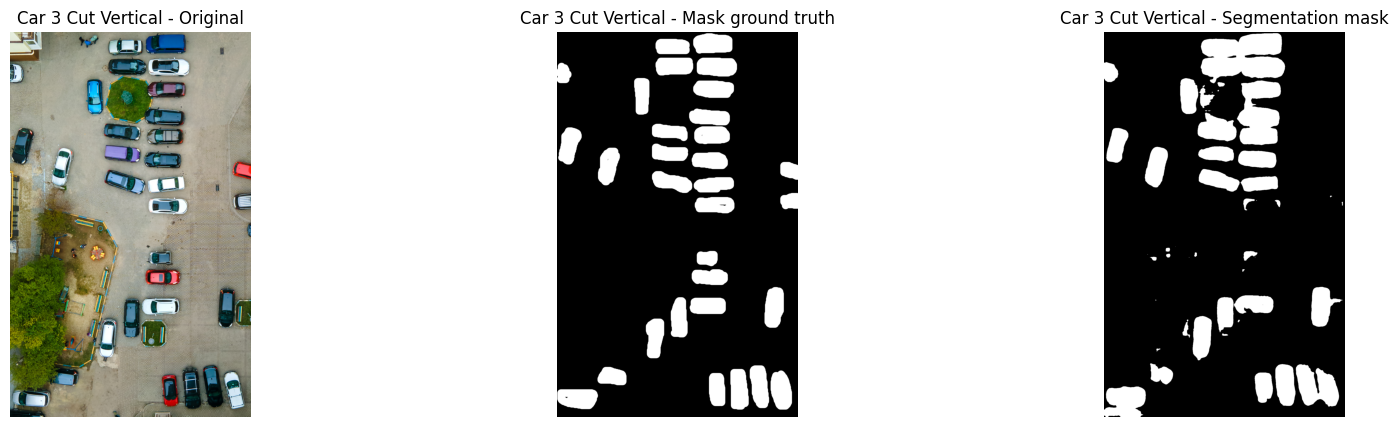

In [17]:
# Get segmentation mask image
car3_vertical, pred_mask_car_vertical_arr3 = semantic_segmentation(model, './cars_startup/car3_vertical.png', min_prob=0.95)
car3_cut, pred_mask_car_cut_arr3 = semantic_segmentation(model, './cars_startup/car3_cut.png', min_prob=0.95)
car3_cut_vertical, pred_mask_car_cut_vertical_arr3 = semantic_segmentation(model, './cars_startup/car3_cut_vertical.png', min_prob=0.95)

# Load ground truth image
_, gt_mask_car_vertical_arr3 = get_img_with_arr('./cars_ground_truth/car3_vertical_ground_truth.png')
_, gt_mask_car_cut_arr3 = get_img_with_arr('./cars_ground_truth/car3_cut_ground_truth.png')
_, gt_mask_car_cut_vertical_arr3 = get_img_with_arr('./cars_ground_truth/car3_cut_vertical_ground_truth.png')

# Ground Truth - Calculate Intersection over Union
print('Intersection over Union -> car3             : ' + str(calculate_iou(pred_mask_car_arr3, gt_mask_car_arr3)))
print('Intersection over Union -> car3 vertical    : ' + str(calculate_iou(pred_mask_car_vertical_arr3, gt_mask_car_vertical_arr3)))
print('Intersection over Union -> car3 cut         : ' + str(calculate_iou(pred_mask_car_cut_arr3, gt_mask_car_cut_arr3)))
print('Intersection over Union -> car3 cut vertical: ' + str(calculate_iou(pred_mask_car_cut_vertical_arr3, gt_mask_car_cut_vertical_arr3)))

# Display original image and masks
show_images({ 'title': 'Car 3 - Original', 'img_data': car3 }, { 'title': 'Car 3 - Mask ground truth', 'img_data': gt_mask_car_arr3 }, { 'title': 'Car 3 - Segmentation mask', 'img_data': pred_mask_car_arr3})
show_images({ 'title': 'Car 3 Vertical - Original', 'img_data': car3_vertical }, { 'title': 'Car 3 Vertical - Mask ground truth', 'img_data': gt_mask_car_vertical_arr3 }, { 'title': 'Car 3 Vertical - Segmentation mask', 'img_data': pred_mask_car_vertical_arr3})
show_images({ 'title': 'Car 3 Cut - Original', 'img_data': car3_cut }, { 'title': 'Car 3 Cut - Mask ground truth', 'img_data': gt_mask_car_cut_arr3 }, { 'title': 'Car 3 Cut - Segmentation mask', 'img_data': pred_mask_car_cut_arr3})
show_images({ 'title': 'Car 3 Cut Vertical - Original', 'img_data': car3_cut_vertical }, { 'title': 'Car 3 Cut Vertical - Mask ground truth', 'img_data': gt_mask_car_cut_vertical_arr3 }, { 'title': 'Car 3 Cut Vertical - Segmentation mask', 'img_data': pred_mask_car_cut_vertical_arr3})